### **READ-ME**


1.   We have Used Google Colab Platform, which consists of our code, graphs, theoretical deductions, report and everything.
2.   Connect the Colab. Then press CTRL + F9 to run the the code.
3.   You will be prompted an authorization link (Block No. 6, 1st Block of Code Section), click on it. Sign-In with your IITJ Google I'd, then copy the authorization code prompted on the screen.
4.   Paste that code in the box designated for it below the link, then whole code runs on it's own.



# **PROGRAMMING ASSIGNMENT**

> ## **Signal And Systems (EEL2010)**

---


           ~Devansh Bansal (B20CS094)
           ~Diksha Jena (B20CS013)


## **Functionalities Built-In required**
---
**Fourier Transform**: *fourier(X,z)*
  

Formula: For Discrete Signal L(e^jw) -> Integration of x(t)exp(-jwt)dt, (t from -inf to +inf)             
Frequency Transform of Discrete Signal is Continous, we will sample it for impulse train of n of length z, where omega(k)=2pie*k/z i.e. for L having frequency samples at expj(2pie(k)/z). {NOTE: omega(k) is in [-pie,pie)}

---
**Inverse Fourier Transform**: *inv_fourier(L,z)*

Formula: As we have a sampled frequency domain L, X(n)= (1/z)sigma[L(exp(jw))*exp(jwn)] , w goes form -pie to pie (excluding either -pie or pie as they correspond to same rate of oscillation.) [or -inf to +inf for continuous DTFT].          
z --> Range (or no. of values for which the function exist)

---
**Division fourier**: *div_fourier(A,B,z)*

Simple Sample-Wise Division of A and B, having same omega. Length of A and B should be same, equal to z.

---
**Debluring**: *deblur(Y,impulse)*

The process of Deconvolution; Output Y and Impulse output have been provided. Since the signal was convoluted in n-domain, it will follow simple multiplication for frequency domain (**Convolution Theorem**):        
(i) Convert y and impulse into frequency domains i.e. take Fourier Transforms.     
(ii) Divide them element-wise, for required sampled frequencies for X.     
(iii) Follow Inverse Fourier Transform to obtain x in n-domain.

---
**Denoising**: *denoise(L)*

Average out the values to minimize to effect of sudden impulses in graph added due to noise.       
Average of 5 values (2 ahead and 2 behind have been taken i.e. element centric approach)      
*3 was not taken, since the noise can be both +ve and -ve, taking 5 values was safer and more accurate*


---


In [ ]:
def fourier(A,N):
  L=np.array([])
  for k in range(-(N//2),(N//2)+1):         # N is the length of Fourier Transfrom (FT), and it also represents the number of partitions made for omega in the range of -pie to pie.
    temp=0
    for n in range(len(A)):
      temp+=A[n]*np.exp(-2j*np.pi*k*n/N)    # As per formula of FT, summation throughout the length of signal is done for particular omega(k).
    L=np.append(L,temp)
  return L

In [ ]:
def inv_fourier(A,N):
  L=np.array([])
  for k in range(len(A)):                         # N is the length of Inverse Fourier Transform (IFT), and it also represents the number of partitions made for omega in the range of -pie to pie.
    temp=0
    for n in range(-(N//2),(N//2)+1):
      temp+=A[n+(N//2)]*np.exp(2j*np.pi*k*n/N)    # As per formula of IFT, summation throughout the length of signal is done for particular omega(k).
    L=np.append(L,np.real(temp/(N+0j)))           # As per formula of IFT, summation is divided by length of signal and real part is stored.
  return L

In [ ]:
def div_fourier(A,B,z):
  L=np.array([])
  for i in range(-(z//2),(z//2)+1):
    if -limit<B[i+(z//2)]<limit:    #-0.707 to 0.707 for ideality
      L=np.append(L,A[i+(z//2)])    
    else:
      L=np.append(L,A[i+(z//2)]/B[i+(z//2)])
  return L

In [ ]:
def deblur(A,impulse):
  z=len(A)-len(impulse)+1   #z determines the no of values required for returning x, depending on its sampling
  return inv_fourier(div_fourier(fourier(A,z),fourier(impulse,z),z),z)

In [ ]:
def denoise(A):
  z=len(A)
  L=np.array([0]*z)
  for i in range(z-2):
    L[i]=(A[i-2]+A[i-1]+A[i]+A[i+1]+A[i+2])/5       # We take centred average of 5 terms, to denoise the signal.
  L[z-2]=(A[z-4]+A[z-3]+A[z-2]+A[z-1]+A[0])/5       # 3 terms led to poor denoising due to high variance of noise, and 7 or 9 terms lead to excessive flatness of curve and nullifying the variance of original input.
  L[z-1]=(A[z-3]+A[z-2]+A[z-1]+A[0]+A[1])/5
  return L

## **Modelling**
We have been provided with sensored values, that have been convoluted (impulse: h_n= 1/16 [1,4,6,4,1] ), and induced with error. Our aim is to obtain the original values.  

As the values are dicrete, sampling needs to be done. The periodicity can be determined after observing the no. of values that have been provided to sample.

The **convolution system of any 2 discrete signals is n+z-1 values, where n is the no of values of input, and z is the range of impulse values.** So the missing extra values which have not been provided, might result in huge errors for corners values. It will be better to analyse the predictibility of our model, if those differences can be minimised for the code.

Since the values of **h_n are centered, its frequency domain will tend to zero for a certain region**. Filtering needs to be done for that region, to avoid errornoius graph having high range values (tending to 10^7).

Denoising system will be responsible for reducing the peaks occuring due to noise, to obtain a smoother graph. 
Deblurring is responsible for deconvolution in N-domain (following the division property of Freq-Domain, the **Convolution Theorem**).

We have to **analyse how the difference in the ordering of Denoising and Debluring effects the final graph obtained.** Focus should be on obtaining a graph as similar and continuous (without fluctuations) as possible to the sensored values.

## **Code**

> ### **Data Processing**

      (1) Connection Established
      (2) Data Imported and Stored as x_input and y_output
      (3) Graph of x and y plotted to check the variation that we require
        > in n-domain
        > in frequency-domain
      (4) Freq-domain graph of impulse plotted to check the range for which H(jw) tends to zero, and needs to be filtered
        > stored and Threshold : thresh_min and thresh_max for starting and ending limit


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline 

#Libraries imported for data reading, calculations and plotting.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/data.csv')    # Data file containing input is read.
#seprated the 2 columns, and print the data type/description of values in each column
x_input=data['x[n]']
y_output=data['y[n]']
h_n=[1/16,4/16,6/16,4/16,1/16]
print(data)

        x[n]     y[n]
0    35.4312  33.3735
1    35.1511  34.3744
2    34.8284  35.7514
3    34.4656  35.5869
4    34.0656  36.0826
..       ...      ...
188  31.4198  33.5967
189  31.7396  31.7135
190  32.0228  32.6819
191  32.2673  30.9260
192  32.4714  34.7257

[193 rows x 2 columns]


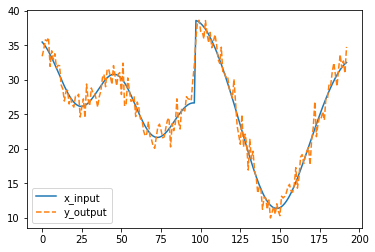

In [ ]:
plt.plot(x_input, label="x_input")
plt.plot(y_output,"--" ,label="y_output")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


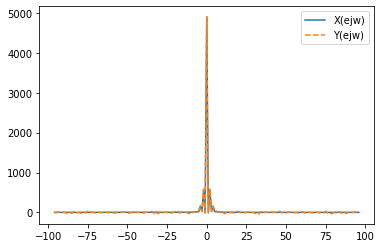

In [ ]:
plt.plot(range(-96,97),fourier(x_input,len(x_input)),label="X(ejw)")
plt.plot(range(-96,97),fourier(y_output,len(x_input)),"--",label="Y(ejw)")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


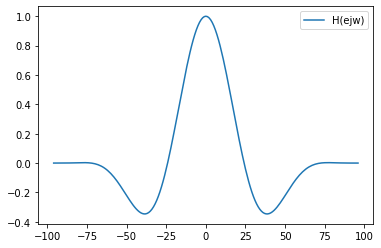

In [ ]:
plt.plot(range(-96,97),fourier(h_n,len(x_input)), label='H(ejw)')
plt.legend()
plt.show()

In [ ]:
limit=0.41
#Observed from the graph above.

> ### **Noise Analyzation**

*   Error Analysation of noise provided, **done only to train the model**, as required x_input has already been provided.       
*   A Convoluted Signal of x_input with impulse h_n was plotted against the given y_output, do observe the noise added, and its %error.

In [ ]:
#comparing and visualizinng the desired, obtained results, and the missing values.
y_input=np.array([])
h_n=[1/16, 4/16, 6/16, 4/16, 1/16]
for n in range(len(x_input)+len(h_n)-1):
  temp=0
  for k in range(5):
    if n-k>-1:
      try:
        temp=temp+x_input[n-k]*h_n[k]
      except:
        pass
  y_input=np.append(y_input,[temp])

print("No. of values in convoluted signal: ", len(y_input))
print("No. of values provided: ", len(y_output))

No. of values in convoluted signal:  197
No. of values provided:  193


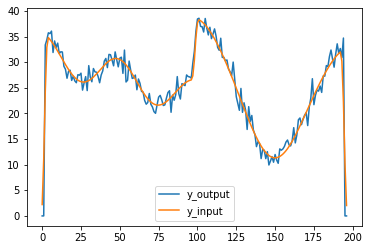

In [ ]:
#Making no. of values provided equal to no. of entries in convoluted signal, by adding zeros to y_output; and plotted.
temp=np.append([0,0],y_output)
temp=np.append(temp,[0,0])
plt.plot(temp, label="y_output")
plt.plot(y_input, label="y_input")
plt.legend()
plt.show()

In [ ]:
#Absolute Error Fraction 
import math
error=0
for i in range(3,len(y_output)-3):
  tk=abs((y_input[i]-y_output[i])/y_input[i])
  if tk>error:
    error=tk
print(error)

0.3179425575862279


> ### **Solution :**

> (a) **Denoise and then sharpen**

     To store and find input value in x_1     
       (1) Copy of y_output array created, to avoid any internal changes.
       (2) Signal denoised, to smoothen the graph (reduce noise).
       (3) Starting and ending values added, as analysed from y_input, for perfect output without any end correction required.
       (4) Deblured and x_1 obtained, plotted.
       (5) Accuracy and deviation analysis done.


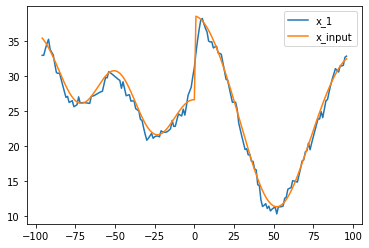

In [ ]:
x_1=np.array(y_output)

x_1=denoise(x_1)                #Denoising Done

x_1=np.append([0,11],x_1)       #End correction included, as per the observation with y_input.
x_1=np.append(x_1,[11,0])
x_1[2]=(x_1[1]+x_1[3])/2
x_1[len(x_1)-3]=(x_1[len(x_1)-2]+x_1[len(x_1)-4])/2

x_1=deblur(x_1,h_n)             #Deblurring done
plt.plot(range(-96,97),x_1, label="x_1")
plt.plot(range(-96,97),x_input, label="x_input")
plt.legend()
plt.show()

In [ ]:
#compare and accuracy matrix, classification report
print('Absolute error:', metrics.mean_absolute_error(x_input, x_1))             #Low values mean Better results
print('Variance:', metrics.mean_squared_error(x_input, x_1))                    #Low values mean Better results
print('Std deviation:', np.sqrt(metrics.mean_squared_error(x_input, x_1)))      #Low values mean Better results 
print('VarScore:',metrics.explained_variance_score(x_input,x_1))                #High values mean Better results (Max. Value = 1)

Absolute error: 0.7830588507649984
Variance: 1.1283613806451536
Std deviation: 1.062243559945248
VarScore: 0.9809619726168385


> (b) **Sharpen and then Denoise**

     To store and find input value in x_2    
       (1) Copy of y_output array created, to avoid any internal changes.
       (2) Starting and Ending values added, as analysed from y_input, for perfect output without any end correction required.
       (3) Deblurred, for deconvoluted error.
       (4) Signal denoised, to reduce the effect of deviation obtained in inverse fourier due to noise.
       (5) Graph plotted 
       (6) Accuracy and Deviation analysis done.


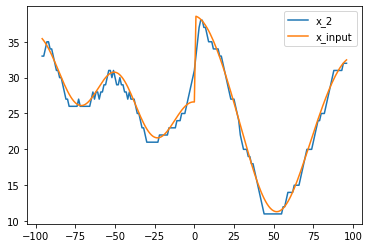

In [ ]:
x_2=np.array(y_output)

x_2=np.append([0,11],x_2)       #End corrections included
x_2=np.append(x_2,[11,0])
x_2[2]=(x_2[1]+x_2[3])/2
x_2[len(x_2)-3]=(x_2[len(x_2)-2]+x_2[len(x_2)-4])/2

x_2=deblur(x_2,h_n)             #Deblurred the output

x_2=denoise(x_2)                #Denoised the Deblurred version of output

plt.plot(range(-96,97),x_2, label="x_2")
plt.plot(range(-96,97),x_input, label="x_input")
plt.legend()
plt.show()

In [ ]:
#compare and accuracy matrix, classification report
print('Absolute error:', metrics.mean_absolute_error(x_input, x_2))             #Low values mean Better results
print('Variance:', metrics.mean_squared_error(x_input, x_2))                    #Low values mean Better results
print('Std deviation:', np.sqrt(metrics.mean_squared_error(x_input, x_2)))      #Low values mean Better results  
print('VarScore:',metrics.explained_variance_score(x_input,x_2))                #High values mean Better results (Max. Value = 1)

Absolute error: 0.7760642487046632
Variance: 1.129277165492228
Std deviation: 1.0626745341317951
VarScore: 0.9802134033124663


> ### **Comparison of standart diviations for different limits**

In [ ]:
array1=[]              #Stores the rms error for Denoising and then Deblurring Solution, for different values of limit set from (0.24 to 0.7, 0.707 is the max possible logically to set)
for i in range(24,71):
  limit=i/100
  x_1=np.array(y_output)
  x_1=denoise(x_1)       
  x_1=np.append([0,11],x_1)
  x_1=np.append(x_1,[11,0])
  x_1[2]=(x_1[1]+x_1[3])/2
  x_1[len(x_1)-3]=(x_1[len(x_1)-2]+x_1[len(x_1)-4])/2

  x_1=deblur(x_1,h_n)    

  array1.append(np.sqrt(metrics.mean_squared_error(x_input, x_1)))
else:
  limit=0.707
  x_1=np.array(y_output)
  x_1=denoise(x_1)        
  x_1=np.append([0,11],x_1)
  x_1=np.append(x_1,[11,0])
  x_1[2]=(x_1[1]+x_1[3])/2
  x_1[len(x_1)-3]=(x_1[len(x_1)-2]+x_1[len(x_1)-4])/2

  x_1=deblur(x_1,h_n)    
  array1.append(np.sqrt(metrics.mean_squared_error(x_input, x_1)))
  x=[i/100 for i in range(24,71)]
  x.append(0.707)

In [ ]:
array2=[]         #Stores the rms error for Deblurring and then Denoising Solution, for different values of limit set from (0.24 to 0.7, 0.707 is the max possible logically to set)
for i in range(24,71):
  limit=i/100
  x_2=np.array(y_output)

  x_2=np.append([0,11],x_2)
  x_2=np.append(x_2,[11,0])
  x_2[2]=(x_2[1]+x_2[3])/2
  x_2[len(x_2)-3]=(x_2[len(x_2)-2]+x_2[len(x_2)-4])/2

  x_2=deblur(x_2,h_n)  
  x_2=denoise(x_2)             
  array2.append(np.sqrt(metrics.mean_squared_error(x_input, x_2)))
else:
  limit=0.707
  x_2=np.array(y_output)

  x_2=np.append([0,11],x_2)
  x_2=np.append(x_2,[11,0])
  x_2[2]=(x_2[1]+x_2[3])/2
  x_2[len(x_2)-3]=(x_2[len(x_2)-2]+x_2[len(x_2)-4])/2

  x_2=deblur(x_2,h_n)    
  array2.append(np.sqrt(metrics.mean_squared_error(x_input, x_2)))
  y=[i/100 for i in range(24,71)]
  y.append(0.707)

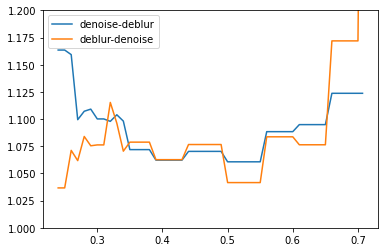

In [ ]:
plt.plot(x,array1,label='denoise-deblur')
plt.plot(y,array2,label='deblur-denoise')
plt.ylim(1, 1.2)
plt.legend()
plt.show()

## **Conclusion (Based on Graphs):**

---


**Observations**
*  ### **Part A:**
 **Fairly accurate graph was obtained**, but the fluctuations were still registered as the noise cannot be perfectly removed.

  Signal close to given input was obtained, with **less fluctutaions** as perfect denoising can't be done.

   For initial samples, the values are somewhat more distorted as compared to samples taken afterwards.
*  ### **Part B:**
 Something **similar to step-functions, with breaks were obtained.** Oscillations were low, but had lower accuracy.
 
   Signal close to given input was obtained, but signal was constant for certain samples and then sudden change was recorded, **like a step function.**
   
  For intial samples, values are somewhat more distorted (even more as compared to Part A), and then values recorded for further samples are close to original signal.


---

**Orange line is lower than Blue line** when approaching ideality, concluding that **Denoising and then Deblurring is a better approach**, to retrieve the input back, when viewed logically and in theory.

But in practice, for a close approximation of **limit in range of 0.35 to 0.48 also, same conclusion can be made**. Even though **reverse conclusion can be drawn for a close approximation of limit in range 0.48 to 0.65**.

In theory an **ideal filter have limit value as 0.707**, but **in practice** the impulse response of filter **doesn't goes to 0 abruptly** after the cut-off frequency and hence for these **end-corrections** we need to **reduce the limit value** in real life. For this case it turns out that around limit=0.41, we obtain best results.

### **Explanation**


*   Since **noise** is a random signal with **average value of 0**, and it's an additive noise (here); So to remove it, **averaging is better approach rather than removing higher frequency components**. Another con of removing higher frequency components is that if there are higher frequency components present in the original input, then that will also be removed and hence loss of important information can be faced.

*   **Blurring** is basically a **Low-Pass Filter** in action. Hence low frequencies are passed as they are in original input, and since it's not an ideal filter higher frequencies are attenuated and not completely removed. Hence we need to use **H(exp(jw)) as 1 for very low frequencies**; for frequencies **lower than cut-off frequency, H(exp(jw)) was based on kernel**; and when **H(exp(jw)) approaches 0, we ignore the factor as it's negligible in comparision**. And also we use the concept of *range of omega being 0 to pie (for practice) instead of -pie to pie; i.e. if cut-off frequency corresponds to 82pie/193 in range of 0 to pie, then it's -82pie/193 in range of -pie to 0.*

*   Since given condition was that *first a pure and clean signal is blurred then additive noise is added to the blurred signal*, so to retrieve also, we need to go on exact reverse path logically speaking, hence we can deduce by arguments that **denoising and then deblurring will give us better results** if we want to retrieve input from output. And by applying concepts of Signals and Systems, doing calculations for eg using *Fourier Transform, Inverse Fourier Transform, Low-Pass Filter, Convolution, Noise-and-Denoising* etc. we got the same inference that **(A) Denoising and then Deblurring is indeed better than (B) Deblurring and then Denoising** to retrieve back the original input from output.

*   **Denoising** first makes the **signal smooth** and hence Fourier Transforms and Inverse Fourier Transform can be applied (to **Deblurr**) in a **better way** and they will give **better results.** Also this can be seen from the graph in Part-A.

*   Whereas **Deblurring** first **doesn't reduce** the abrupt changes in the signal which are random (**noise** to be precise), and hence Inverse Fourier Transforms **contain some frequency elements which were not there in original input**, and hence Denoising afterwards also can't remove them (it just reduces variance and make the signal uniform); and this leads to **incorrect results.**

### **FINAL CONCLUSION**


*   **Denoising-and-then-Deblurring** is better than Deblurring-and-then-Denoising to retrieve a signal back which was blurred and then denoised.

## **Result**

---
We must **First Denoise** the signal and **Then Deblurr** it, to get more accurate results.


### **Contribution:**

  (1) Devansh Bansal: Prepared the Basic Workflow and Ideation behind the solution, Deduced the logic of Low-Pass-Filter (together), Denoising and Implementing Inverse Transform for Deblurring. Theoretical deduction of results. Final Debugging and did end-correction which made the result more accurate. Also made this Colab presentable. Performed Proof-Reading.
  
  (2) Diksha Jena: Prepared this Colab Workbook, Written majority of the code (75-80%) along with Debugging, Deciding the most accurate approach, Modelling the procedure, Implementation of idea, Observation and verification of results, Deduced the logic of Low-Pass-Filter (together). Responsible for last-check of Colab.
  
